## Capstone EDA
This notebook explores the data by doing Exploratory Data Analysis.

In [109]:
pip install "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [173]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [174]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [226]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import dask.bag as bag
import numpy as np
import pandas as pd
import cv2
import warnings

from dask.diagnostics import ProgressBar
from PIL import Image
from pathlib import Path
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern


warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [219]:
imageDatasetPath = str(Path().absolute()) + "/Rice_Image_Dataset"
# Read from folders in the OS
folders = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
foldersPath = [
    imageDatasetPath + "/" + folders[0] + "/", 
    imageDatasetPath + "/" + folders[1] + "/", 
    imageDatasetPath + "/" + folders[2] + "/", 
    imageDatasetPath + "/" + folders[3] + "/", 
    imageDatasetPath + "/" + folders[4] + "/"
]
# Define colors for each class
colors = ['red', 'green', 'blue', 'orange', 'purple']

## Checking the number of imagers per class

In [64]:
totalPerClass = {
    folders[0]: len(os.listdir(foldersPath[0])),
    folders[1]: len(os.listdir(foldersPath[1])),
    folders[2]: len(os.listdir(foldersPath[2])),
    folders[3]: len(os.listdir(foldersPath[3])),
    folders[4]: len(os.listdir(foldersPath[4])),
}

In [65]:
totalPerClass

{'Arborio': 15000,
 'Basmati': 15000,
 'Ipsala': 15000,
 'Jasmine': 15000,
 'Karacadag': 15000}

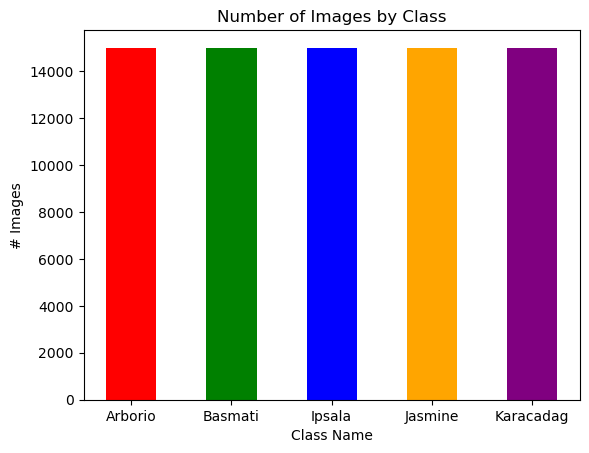

In [220]:
plt.bar(totalPerClass.keys(), totalPerClass.values(), width = .5, color=colors);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

## Check if all the images are in grayscale

In [237]:
def are_all_images_grayscale(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if len(image.shape) != 2 or image.shape[2] != 1:
                return False
    return True

In [238]:
for idx, d in enumerate(foldersPath):
    filepath = d
    if are_all_images_grayscale(filepath):
        print(f"All images in {folders[idx]} are grayscale.")
    else:
        print(f"Not all images in in {folders[idx]} are grayscale.")

Not all images in in Arborio are grayscale.
Not all images in in Basmati are grayscale.
Not all images in in Ipsala are grayscale.
Not all images in in Jasmine are grayscale.
Not all images in in Karacadag are grayscale.


## Check the image samples visually

In [103]:
ncols = 4
nrows = 4
def show_image_sample(pic_directory):
    '''display 4x4 images'''
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i, img_path in enumerate(pic_directory):
        img = mpimg.imread(img_path)
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        plt.imshow(img)
        plt.title('{}'.format(os.path.basename(img_path)))
    plt.show()

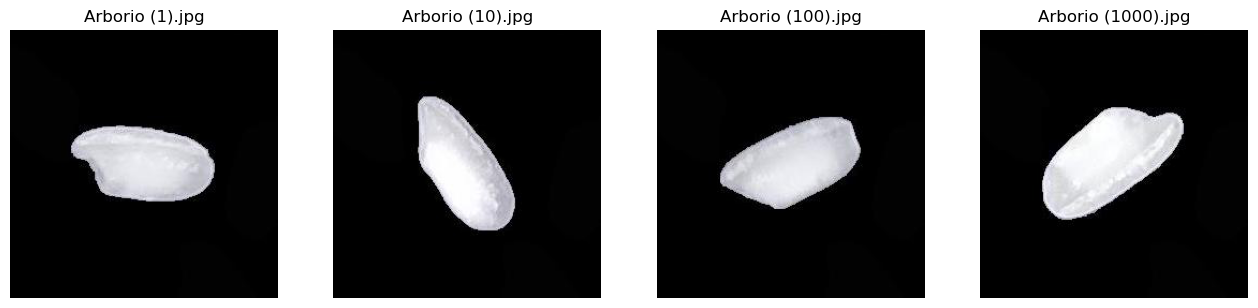

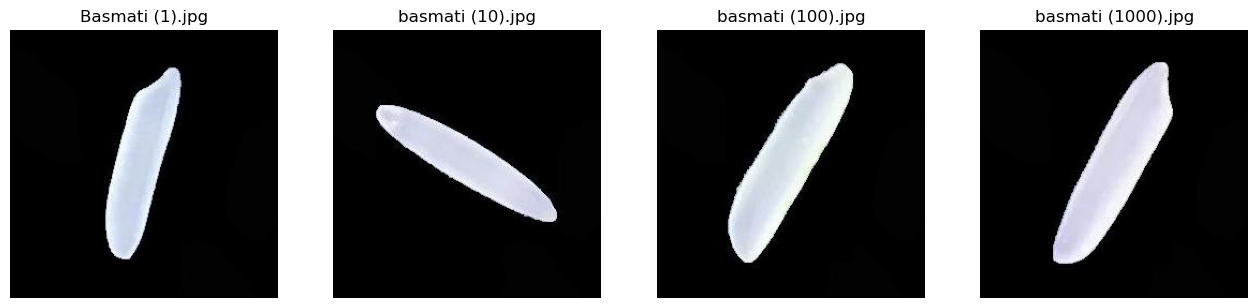

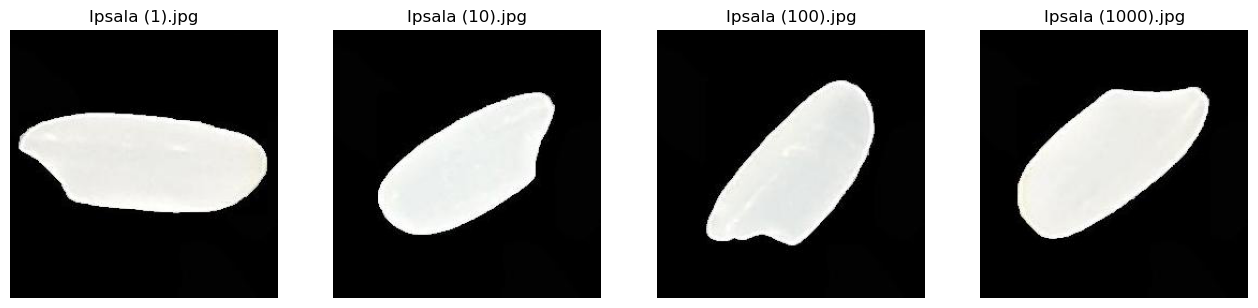

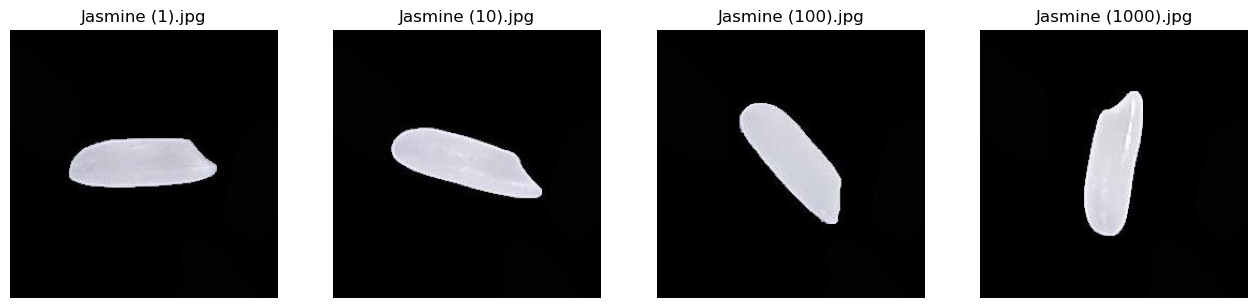

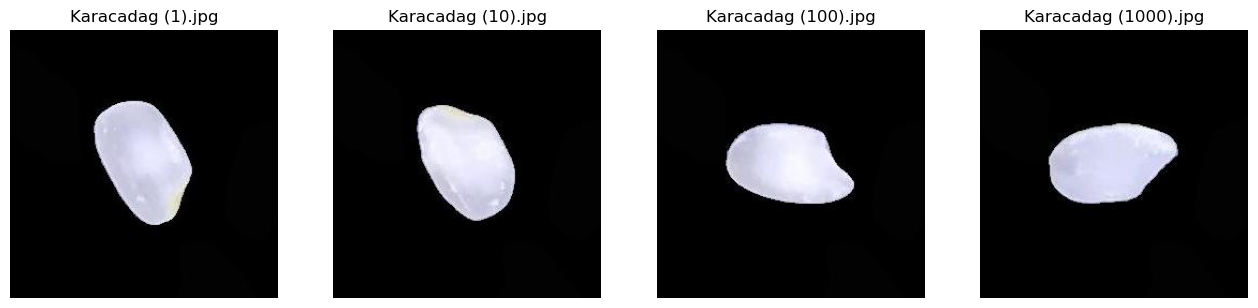

In [115]:
for idx, d in enumerate(foldersPath):
#     show_image_sample(Class_0)
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    filelist = filelist[:4]
    show_image_sample(filelist)

## Checking the dimensions of the image samples

In [67]:
def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

[########################################] | 100% Completed | 2.10 ss
[########################################] | 100% Completed | 2.12 ss
[########################################] | 100% Completed | 2.14 ss
[########################################] | 100% Completed | 2.19 ss
[########################################] | 100% Completed | 2.10 ss


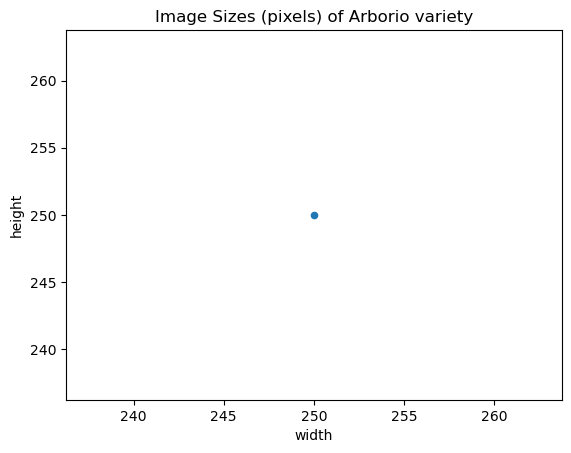

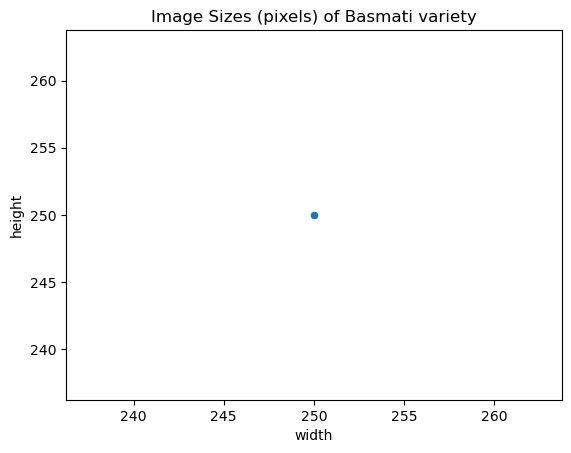

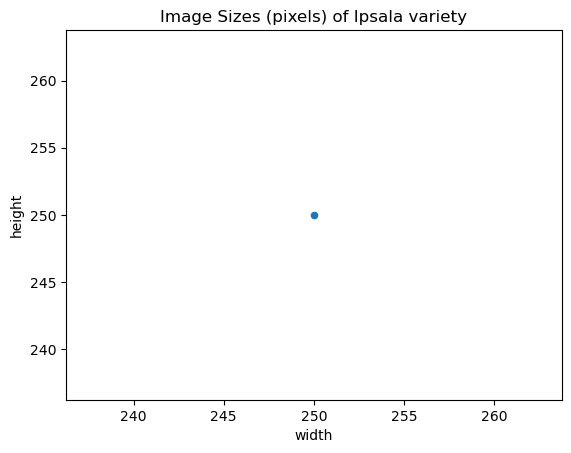

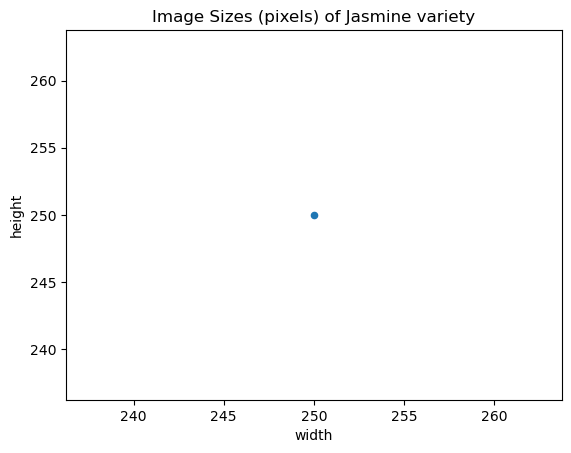

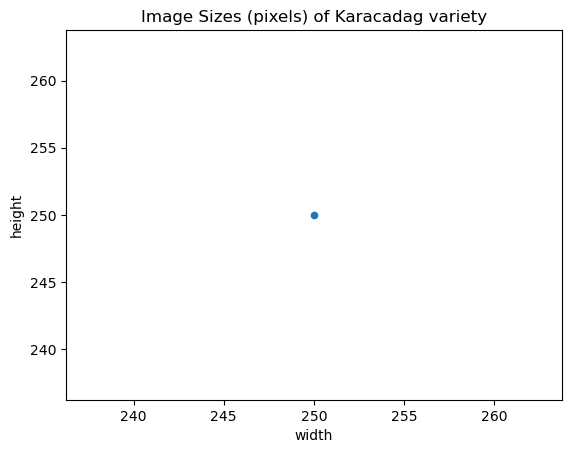

In [105]:
for idx, d in enumerate(foldersPath):
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) of {} variety'.format(folders[idx]))
    

plt.show()

## Grayscale Analysis

In [168]:
def plot_histogram(image_paths, class_name):
    # Create an empty list to store pixel intensities
    pixel_values = []

    # Loop through each image and compute pixel intensities
    for image_path in image_paths:
        # Read the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Threshold the image to remove black pixels
        _, thresh = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)
        image_no_black = cv2.bitwise_and(image, thresh)
        
        # Flatten the 2D image array to a 1D array
        pixel_values.extend(image_no_black.flatten())
    
    # Remove the black values since that will not give the correct impression
#     pixel_values = [val for val in pixel_values if val >= 10]
    
    # Compute histogram
    hist, bins = np.histogram(pixel_values, bins=256, range=(1, 256))

    # Plot histogram
    plt.plot(hist, color='black')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Pixel Intensities ({class_name})')
    plt.show()

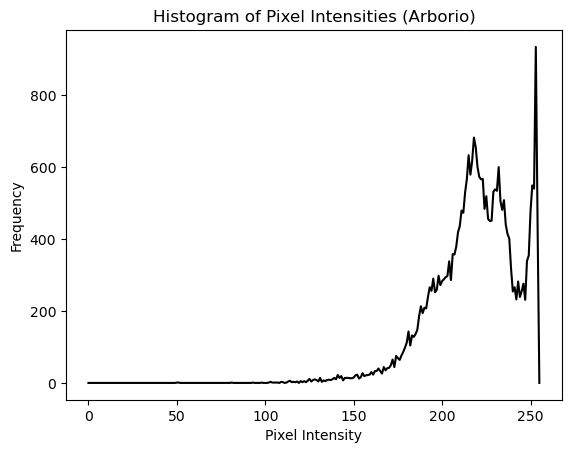

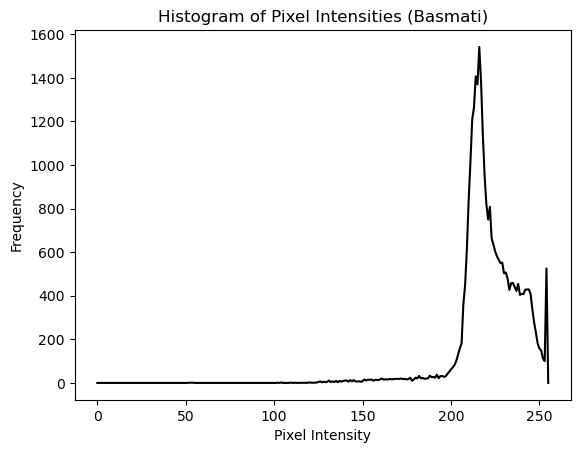

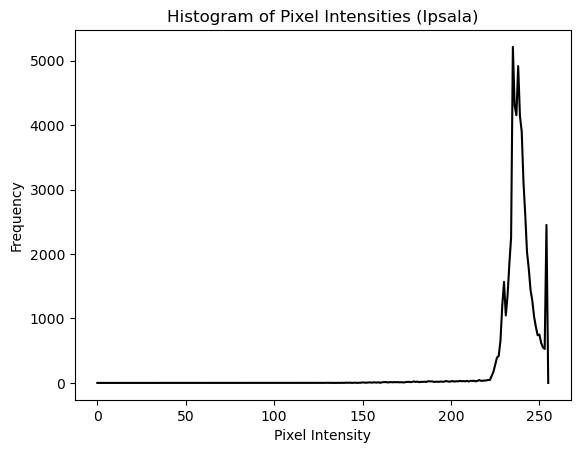

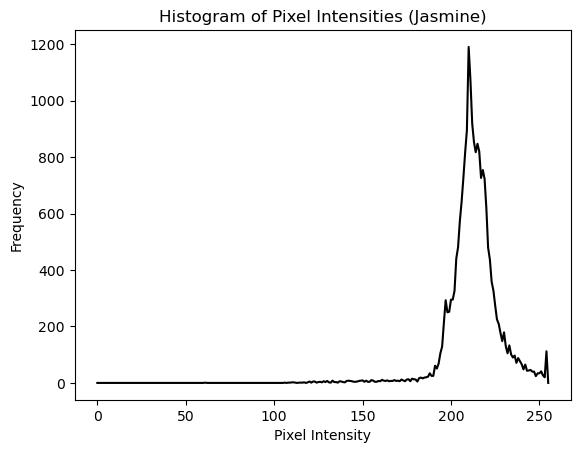

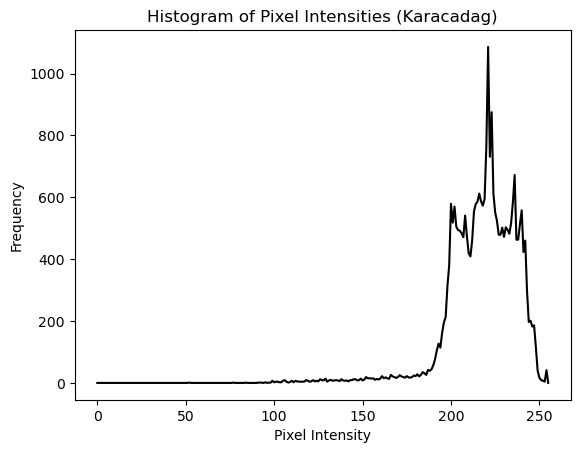

In [170]:
for idx, d in enumerate(foldersPath):
#     show_image_sample(Class_0)
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    filelist = filelist[:4]
    plot_histogram(filelist, folders[idx])

## Texture Analysis

In [223]:
def compute_glcms(image):
    # Compute GLCMs
    distances = [1, 2, 3]  # Define distances for GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define angles for GLCM
    glcms = greycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
    return glcms

def compute_texture_features(glcms):
    # Compute texture features from GLCMs
    contrast = greycoprops(glcms, 'contrast')
    dissimilarity = greycoprops(glcms, 'dissimilarity')
    homogeneity = greycoprops(glcms, 'homogeneity')
    energy = greycoprops(glcms, 'energy')
    correlation = greycoprops(glcms, 'correlation')
    return contrast.mean(), dissimilarity.mean(), homogeneity.mean(), energy.mean(), correlation.mean()

def compute_lbp(image):
    # Compute Local Binary Pattern (LBP)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp

def plot_simple_histogram(data, title):
    plt.figure()
    plt.hist(data.ravel(), bins=256, range=(0, 256))
    plt.title(title)
    plt.show()

def analyze_texture(image_paths, class_name):
    # Create an empty list to store pixel intensities
    pixel_values = []

    # Loop through each image and compute pixel intensities
    for image_path in image_paths:
        # Read the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Compute GLCMs and texture features
        glcms = compute_glcms(image)
        contrast, dissimilarity, homogeneity, energy, correlation = compute_texture_features(glcms)

        # Save this to each class and make is a paragrap
        return contrast, dissimilarity, homogeneity, energy, correlation


In [227]:
analyzedTexture = {}

for idx, d in enumerate(foldersPath):
#     show_image_sample(Class_0)
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    filelist = filelist[:4]
    contrast, dissimilarity, homogeneity, energy, correlation = analyze_texture(filelist, folders[idx])
    analyzedTexture[folders[idx]] = {
        "contrast": contrast,
        "dissimilarity": dissimilarity,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation
    }

C:\Users\asus\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\asus\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\asus\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\asus\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\asus\anaconda3\lib\site-packa

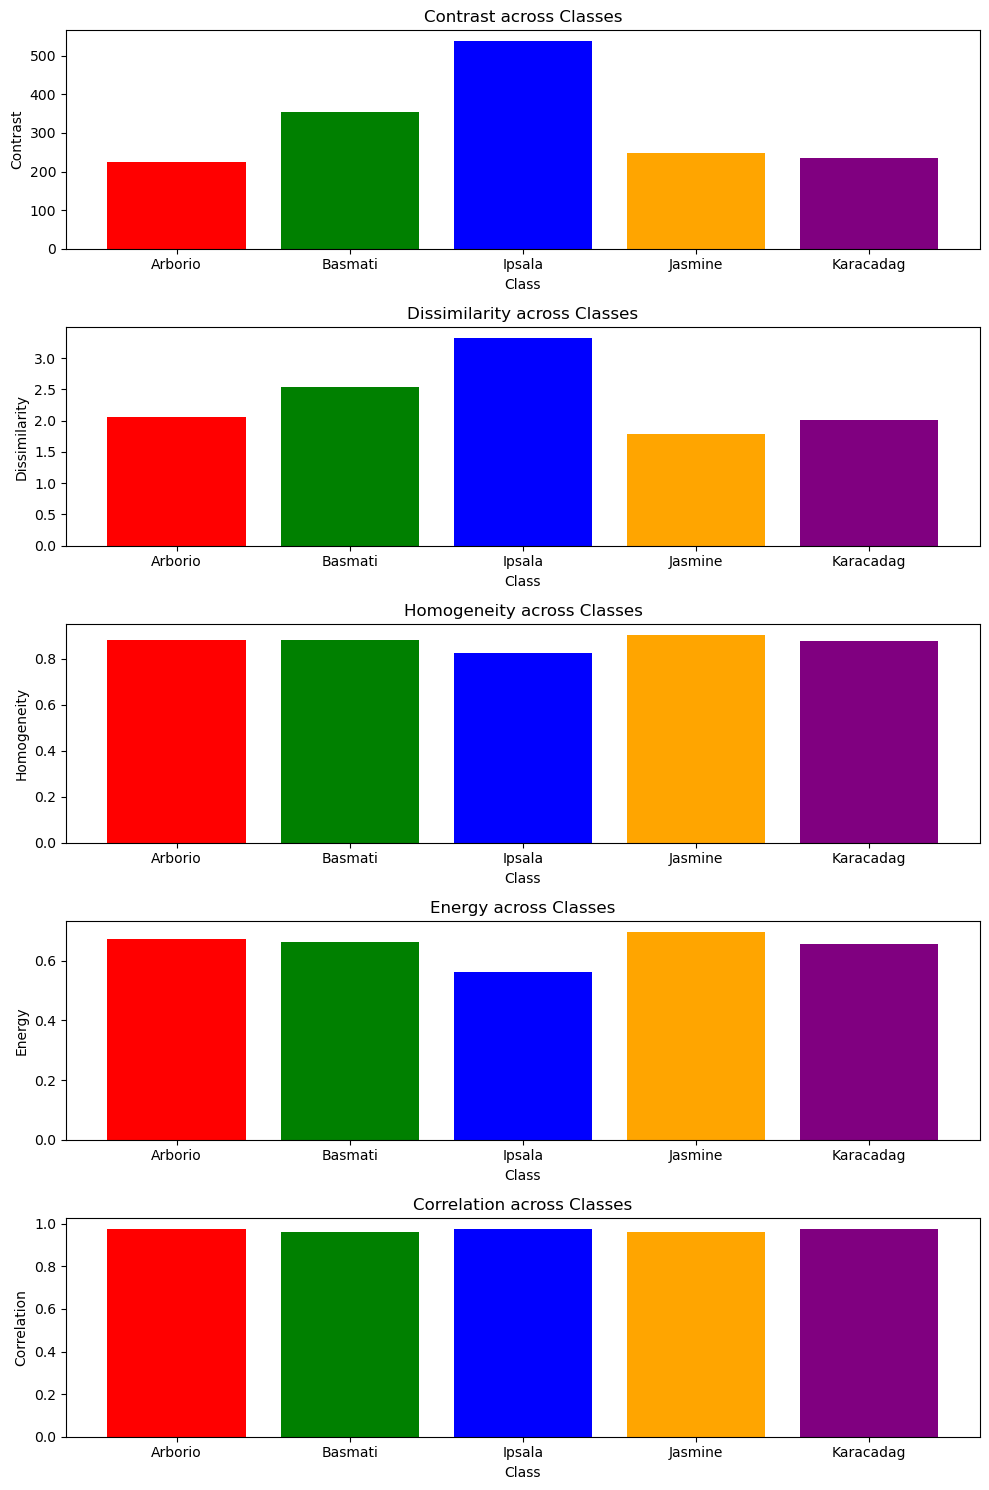

In [225]:
# Extract texture features and class names
class_names = list(analyzedTexture.keys())
texture_labels = list(analyzedTexture[class_names[0]].keys())

# Plot each texture feature for each class
num_features = len(texture_labels)
num_classes = len(class_names)
fig, axes = plt.subplots(num_features, 1, figsize=(10, 15))

for i, feature in enumerate(texture_labels):
    # Get the values for this feature across all classes
    values = [analyzedTexture[class_name][feature] for class_name in class_names]
    # Plot the values for this feature
    for j, class_name in enumerate(class_names):
        axes[i].bar(class_name, values[j], color=colors[j], label=class_name)

    axes[i].set_ylabel(feature.capitalize())
    axes[i].set_xlabel('Class')
    axes[i].set_title(f'{feature.capitalize()} across Classes')

plt.tight_layout()
plt.show()

In [239]:
import tensorflow as tf

In [240]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [242]:
tf.__version__

'2.12.0'